In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
"""
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
print("Num GPUs Available: ", len(physical_devices))""";

In [2]:
akarsu_df = pd.read_csv('../RelevantData/akarsu_relevant.csv', parse_dates = ['Tarih'], index_col = 'Tarih')
"""
deniz_df = pd.read_csv('../RelevantData/deniz_relevant.csv', parse_dates = ['Tarih'], index_col = 'Tarih')
gol_df = pd.read_csv('../RelevantData/gol_relevant.csv', parse_dates = ['Tarih'], index_col = 'Tarih')
aritma_df = pd.read_csv('../RelevantData/aritma_relevant.csv', parse_dates = ['Tarih'], index_col = 'Tarih')
""";

In [3]:
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [4]:
akarsu_cols = ['Fekal_Koliform', 'Toplam_Koliform', 'Toplam_Fosfor', 'Toplam_Kjeldahl_Azotu', 'Kimyasal_Oksijen_İhtiyacı', 'Nitrat_Azotu', 'Çözünmüş_Oksijen']
'''
gol_outliers = ['Toplam_Fosfor', 'Toplam_Azot', 'Klorofil']
deniz_outliers = ['Toplam_Koliform', 'Fekal_Koliform', 'Amonyak', 'Fekal_Streptokok']
aritma_outliers = ['Biyokimyasal_Oksijen_İhtiyacı', 'Kimyasal_Oksijen_İhtiyacı', 'Toplam_Fosfor', 'Toplam_Azot']
''';

In [5]:
akarsu_df

,Numune_Adı,Fekal_Koliform,Toplam_Koliform,Toplam_Fosfor,Toplam_Kjeldahl_Azotu,Toplam_Pestisit,Kimyasal_Oksijen_İhtiyacı,Nitrat_Azotu,Çözünmüş_Oksijen
Tarih,,,,,,,,,
05/07/02 00:00:00,BLYS001,1900.00000,2100.00000,0.10000,NaN,NaN,4.99995,0.69000,7.34000
05/07/02 00:00:00,BLYS002,1800.00000,2200.00000,0.05700,NaN,NaN,5.57000,0.42700,6.59000
05/07/02 00:00:00,BLYS003,1600.00000,2200.00000,0.00700,NaN,NaN,6.60000,0.47800,10.93000
05/07/03 00:00:00,BLYS004,1200.00000,1600.00000,4.50000,NaN,NaN,35.40000,0.08700,1.54000
05/07/03 00:00:00,BLYS005,1600.00000,2000.00000,1.42000,NaN,NaN,28.20000,0.04800,1.96000
...,...,...,...,...,...,...,...,...,...
NaN,TGYS189,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18.12.2016,A54,0.00000,3000.00000,0.20000,13.30000,NaN,30.70000,0.02300,85.60000
NaN,A55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# Removing Toplam_Pestisit column because 90% of it is empty.
akarsu_df = akarsu_df.drop(columns = 'Toplam_Pestisit')
# Dropping missing features
akarsu_df = akarsu_df.dropna()
# Manually correcting dates of two samples
akarsu_df.index = akarsu_df.index.str.replace("28:.12.2016", "28.12.2016", regex = True)
akarsu_df.index = akarsu_df.index.str.replace("22.009.2016", "22.09.2016", regex = True)

In [7]:
# Scale features
akarsu_scaled = akarsu_df.copy()
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
for i in akarsu_cols:
    akarsu_scaled[[i]] = scaler.fit_transform(akarsu_df[[i]])

akarsu_scaled.index = pd.to_datetime(akarsu_scaled.index, yearfirst = True)
akarsu_df.index = pd.to_datetime(akarsu_df.index, yearfirst = True)
df = akarsu_scaled
#df = akarsu_df

In [8]:
df['chunkID'] = df.groupby('Numune_Adı').ngroup()
df = df.drop(labels = ['Numune_Adı'], axis = 1)
df = df.sort_values(by=['chunkID', 'Tarih'])

In [9]:
# Split Data
test_df = df.loc[df['chunkID'] == 43]
df = df[df['chunkID'] != 43]
data = df.drop(columns = 'chunkID')
test_df = test_df.drop(columns = 'chunkID')

n_timesteps = 4 # Length of the output sequences
batch_size = 8 # Number of timeseries samples in each batch

rows_per_month = 1
test_months = 12 # last # of rows to split
test_indices = test_months * rows_per_month    

train = data.iloc[:-test_indices]
#test = data.iloc[-test_indices:]
test = test_df
test_idx = test_df.index

In [10]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
# Generate timeseries data
train_generator = TimeseriesGenerator(train.values, targets = train.values, length = n_timesteps, batch_size = batch_size)
test_generator = TimeseriesGenerator(test.values, targets = test.values, length = 1, batch_size = 1)

Create Model( N=100 ) 

In [11]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Activation, Input, LeakyReLU

neurons = 100
input_layer = Input(shape = (n_timesteps, train.shape[1]))
lstm1, state_h, state_c = LSTM(neurons, return_sequences=True, return_state=True)(input_layer)
lstm2 = LSTM(neurons)(lstm1)
act = LeakyReLU(alpha=0.01)(lstm2)
dense = Dense(train.shape[1])(act)
act = LeakyReLU(alpha=0.1)(dense)
model = Model(inputs=input_layer, outputs=[act])
model.summary()
model.compile(optimizer='adam', loss = 'mse', metrics= ['accuracy'])
num_epochs = 10
history = model.fit(train_generator, epochs = num_epochs)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4, 7)]            0         
_________________________________________________________________
lstm (LSTM)                  [(None, 4, 100), (None, 1 43200     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 7)                 707       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7)                 0         
Total params: 124,307
Trainable params: 124,307
Non-trainable params: 0
_______________________________________________________

Advantages of using LeakyReLU: Avoid Dying Neurouns
    
    Dying ReLU

    During training, some neurons effectively die, meaning they stop outputting anything other than 0. In some cases, you may find that half of your network’s neurons are dead, especially if you used a large learning rate. A neuron dies when its weights get tweaked in such a way that the weighted sum of its inputs are negative for all instances in the training set. When this happens, it just keeps outputting 0s, and gradient descent does not affect it anymore since the gradient of the ReLU function is 0 when its input is negative.

    Hands-on Machine Learning [2], page 329

In [12]:
pred = pd.DataFrame(model.predict(test_generator))
pred_df = pd.DataFrame(scaler.inverse_transform(pred))
pred_df.columns = data.columns.values
pred_df.index = test_idx.delete(73)
test_df = pd.DataFrame(scaler.inverse_transform(test))
test_df.columns = data.columns.values
test_df = test_df.drop(test_df.tail(1).index, axis = 0)
test_df.index = test_idx.delete(73)

Create model with n = 200

In [13]:
neurons = 200
input_layer = Input(shape = (n_timesteps, train.shape[1]))
lstm1, state_h, state_c = LSTM(neurons, return_sequences=True, return_state=True)(input_layer)
lstm2 = LSTM(neurons)(lstm1)
act = LeakyReLU(alpha=0.01)(lstm2)
dense = Dense(train.shape[1])(act)
act = LeakyReLU(alpha=0.1)(dense)
model = Model(inputs=input_layer, outputs=[act])
model.summary()
model.compile(optimizer='adam', loss = 'mse', metrics= ['accuracy'])

num_epochs = 10
history2 = model.fit(train_generator, epochs = num_epochs)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 4, 7)]            0         
_________________________________________________________________
lstm_2 (LSTM)                [(None, 4, 200), (None, 2 166400    
_________________________________________________________________
lstm_3 (LSTM)                (None, 200)               320800    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 1407      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 7)                 0         
Total params: 488,607
Trainable params: 488,607
Non-trainable params: 0
_____________________________________________________

In [14]:
pred = pd.DataFrame(model.predict(test_generator))
pred_df2 = pd.DataFrame(scaler.inverse_transform(pred))
pred_df2.columns = data.columns.values
pred_df2.index = test_idx.delete(73)

Create model with n=500

In [15]:
neurons = 500
input_layer = Input(shape = (n_timesteps, train.shape[1]))
lstm1, state_h, state_c = LSTM(neurons, return_sequences=True, return_state=True)(input_layer)
lstm2 = LSTM(neurons)(lstm1)
act = LeakyReLU(alpha=0.1)(lstm2)
dense = Dense(train.shape[1])(act)
act = LeakyReLU(alpha=0.1)(dense)
model = Model(inputs=input_layer, outputs=[act])
model.summary()
model.compile(optimizer='adam', loss = 'mse', metrics= ['accuracy'])

num_epochs = 10
history3 = model.fit(train_generator, epochs = num_epochs)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 4, 7)]            0         
_________________________________________________________________
lstm_4 (LSTM)                [(None, 4, 500), (None, 5 1016000   
_________________________________________________________________
lstm_5 (LSTM)                (None, 500)               2002000   
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 500)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 3507      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 7)                 0         
Total params: 3,021,507
Trainable params: 3,021,507
Non-trainable params: 0
_________________________________________________

In [16]:
pred = pd.DataFrame(model.predict(test_generator))
pred_df3 = pd.DataFrame(scaler.inverse_transform(pred))
pred_df3.columns = data.columns.values
pred_df3.index = test_idx.delete(73)

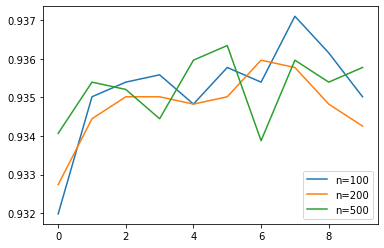

In [17]:
plt.plot(history.history['accuracy'], label = "n=100")
plt.plot(history2.history['accuracy'], label = "n=200")
plt.plot(history3.history['accuracy'], label = "n=500")
plt.legend(loc = 'lower right')

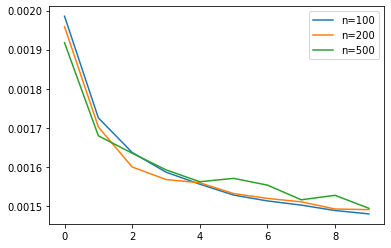

In [18]:
plt.plot(history.history['loss'], label = "n=100")
plt.plot(history2.history['loss'], label = "n=200")
plt.plot(history3.history['loss'], label = "n=500")
plt.legend(loc = 'upper right')

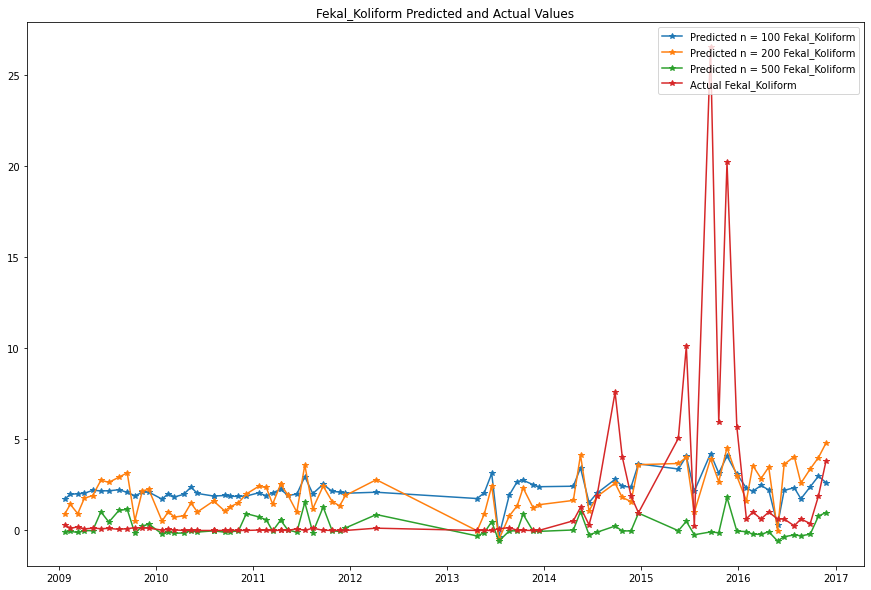

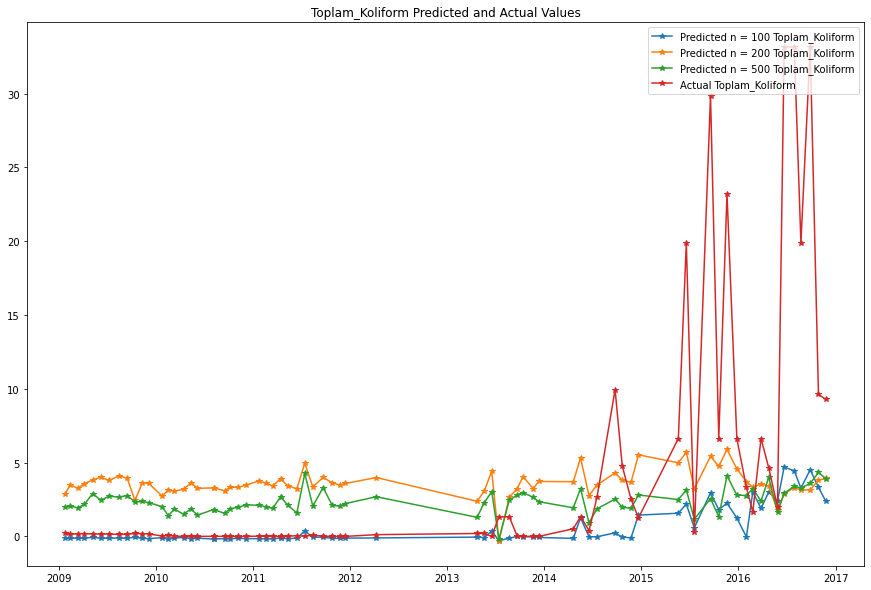

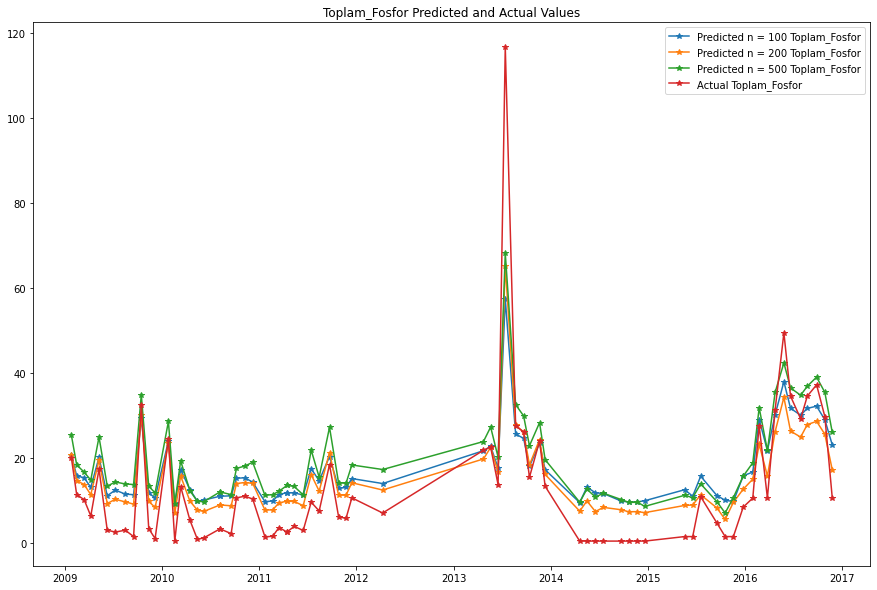

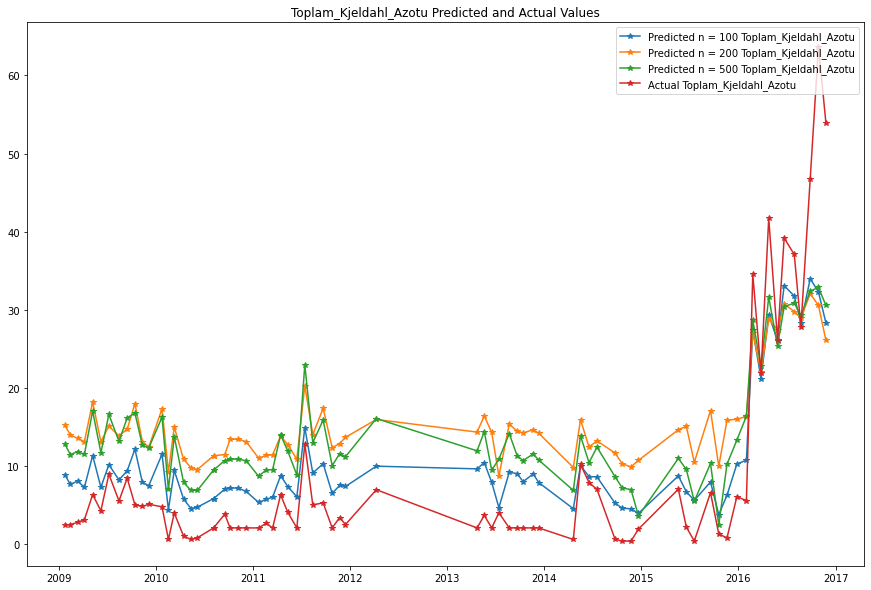

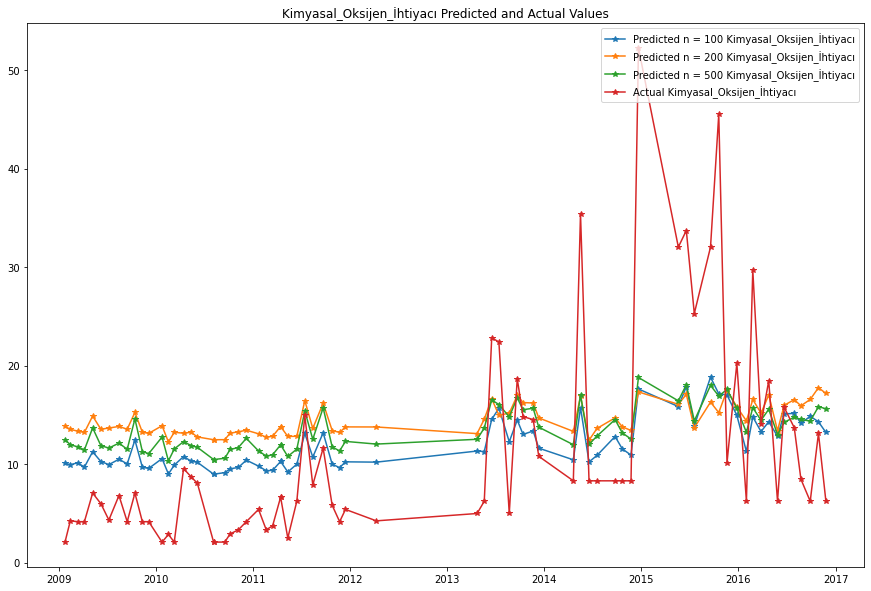

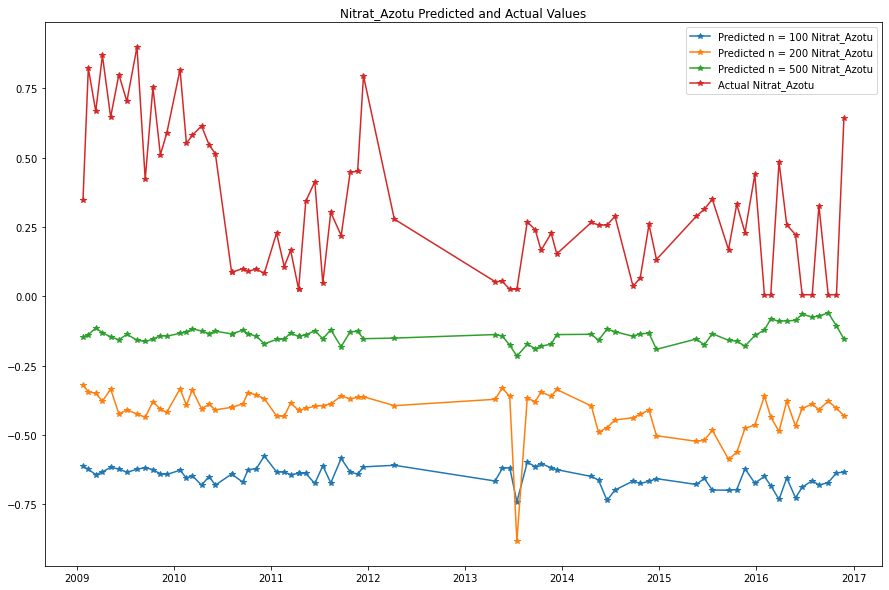

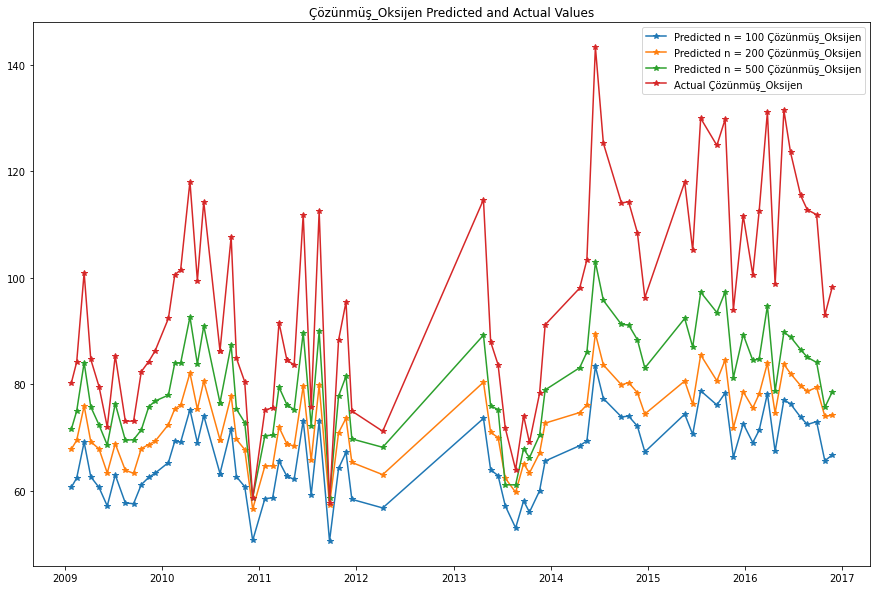

In [19]:
length = len(data.columns.values)
for col_idx in range(length):
    #col_idx = 4 # Pick a col_idx between 0-6
    plt.figure(figsize = [15, 10])
    plt.title(akarsu_cols[col_idx] + " Predicted and Actual Values")
    plt.plot(pred_df[akarsu_cols[col_idx]], label = ("Predicted n = 100 " + akarsu_cols[col_idx]), marker = '*')
    plt.plot(pred_df2[akarsu_cols[col_idx]], label = ("Predicted n = 200 " + akarsu_cols[col_idx]), marker = '*')
    plt.plot(pred_df3[akarsu_cols[col_idx]], label = ("Predicted n = 500 " + akarsu_cols[col_idx]), marker = '*')
    plt.plot(test_df[akarsu_cols[col_idx]], label = ("Actual " + akarsu_cols[col_idx]), marker = '*')
    plt.legend(loc = 'upper right')